# Raport 1: Generowanie zmiennych losowych.

#### Agata Żabska 268760, Szymon Stano 268776
---

## Zaimportowanie niezbędnych bibliotek i funkcji:

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
import scipy.stats
from numba import njit
import matplotlib.ticker as ticker
import numpy.random
import scipy.special
from time import time

## 1. Generator MRG32k3a.

Poniżej przedstawiliśmy algorytm generowania liczb pseudolosowych metodą MRG32k3a. Jest to prosta reguła rekurencyjna, a implementacja bazowała na minimalnym zużyciu pamięci. W następnych krokach sprawdziliśmy czy wygenerowany przez niego ciąg może być porównany do ciągu zmiennych losowych o rozkładzie jednostajnym $U(0,1)$.

In [97]:
# definiujemy potrzebne stałe oraz rozmiar próby
m1 = 2**32 - 209 
m2 = 2**32 - 22853
n = 10**5

# tworzymy tablice odpowiednich rozmiarów oraz ustawiamy ziarno
x, y = np.empty([2, 4])
u = np.empty(n)
x[[0, 1, 2]] = 3, 2, 1
y[[0, 1, 2]] = 3, 2, 1


"""Poniższa pętla generuje kolejne liczby pseudolosowe, które zapisywane są na ostatnich miejscach bazowych tablic X i Y. 
Ostatnią fazą każdej iteracji jest "przesunięcie" elementów w tych tablicach, przez co kolejna iteracja jest prawidłowa,
nie zużywając przy tym niepotrzebnie pamięci."""

t = perf_counter()
for k in range(3, n):
    x[3] = (1403580*x[1] - 810728*x[0]) % m1
    y[3] = (527612*y[2] - 1370589*y[0]) % m2
    if x[3] <= y[3]:
        u[k] = (x[3] - y[3] + m1) / (m1 + 1)
    else:
        u[k] = (x[3] - y[3]) / (m1 + 1)
    x[[0, 1, 2]] = x[[1, 2, 3]]
    y[[0, 1, 2]] = y[[1, 2, 3]]

t2 = perf_counter()
print(f'Czas generowania: {t2-t}')

Czas generowania: 1.1306022000007943


#### Wykres fazowy:

Wizualnym testem, który może sugerować "losowość" w występowaniu liczb pseudolosowych jest wykres fazowy. Bazuje on na wektorach przesunięcia pomiędzy oddalonymi o siebie o daną ilość generacji liczb pseudolosowych. Poniższy przykład dla odstępu rzędu 20 generacji potwierdza posiadanie porządanej przez nas cechy tego generatora.

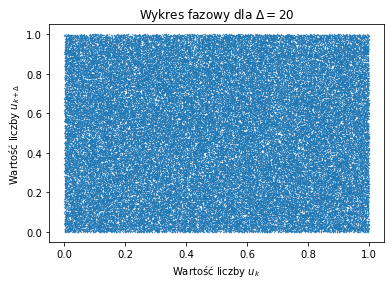

In [117]:
u_delta = np.empty(n)
delta = 20
for i in range(n-1-delta):
    u_delta[i] = u[i+delta]
plt.scatter(u, u_delta, s=0.1)
plt.title(f"Wykres fazowy dla $\Delta = {delta}$")
plt.xlabel("Wartość liczby $u_k$")
plt.ylabel("Wartość liczby $u_{k+\Delta}$")
plt.show()

#### Histogram:

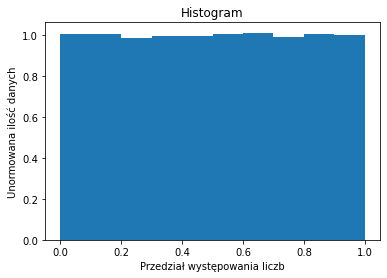

In [99]:
plt.hist(u, density=True)
plt.title("Histogram")
plt.xlabel("Przedział występowania liczb")
plt.ylabel("Unormowana ilość danych")
plt.show()

Jak możemy zaobserwować, unormowany histogram zbliżony jest do funkcji gęstości rozkładu jednostajnego $U(0,1)$. Wyniki te zgodne są z założeniami, potwierdzjąc tym samym poprawność symulacji.

#### Wnioski:
* Otrzymane liczby pseudolosowe z użyciem generatora MRG32k3a przejawiają cechy zbliżone do ciągu zmiennych losowych o rozkładzie $U(0,1)$.

## 2. Metoda akceptacji-odrzucenia.

Kluczowym do rozwiązania tego problemu było wyznaczenie odpowiedniej stałej $c$, która wpływa na skuteczność zaimplementowanego algorytmu. W tym celu wykonaliśmy odpowiednie przekształcenia. Wynikiem, który uznaliśmy za najbardziej optymalny, było $ c = \lfloor \frac{\lambda}{1-p} \rfloor $. Na jego podstawie, a także na podstawie analizy wykresu funkcji mas prawdopodobieństwa obydwu rozkładów, można wnioskować, że im mniejszy parametr $p$ rozkładu geometrycznego, tym skuteczność metody jest większa. W naszych obliczeniach przyjęliśmy $p = 0.1$.

In [100]:
@njit
def fct(n):
    """Zdefiniowana funkcja silni, wolniejsza od np.math.factorial, ale kompatybilna z Numba"""
    return np.prod(np.arange(1, n+1))


@njit
def acceptance_rejection(samples, lmbd, p):
    """Funkcja przyjmuje trzy wartości:
    samples - ilość próbek rozkładu Poissona które chcemy wygenerować
    lmbd - parametr lambda generowanego rozkładu Poissina
    p - parametr rozkładu geomtrycznego (prawdopodobieństwo sukcesu)
    
    Zwraca ona natomiast dwa elementy:
    outputs - wygenerowane próbki
    total_num - liczbę wszystkich powtórzeń, służącą do liczenia skuteczności
    
    Funkcja ta jest implementacją metody akceptacji-odrzucenia generowania
    rozkładu Poissona na podstawie rozkładu geometrycznego"""
    k = int(np.floor(lmbd/(1-p)))
    if k < 1:   # możliwa jest sytuacja, że powyższe wyrażenie będzie równe 0
        k = 1   # nie ma to jednak odzwierciedlenia w przypadku rozkładu geometrycznego, stąd wartość 1
    c = np.exp(-lmbd) * lmbd**k / (fct(k) * p * (1-p)**(k-1))
    outputs = np.empty(samples)
    index = 0
    total_num = 0
    while index < samples:
        x = np.ceil((np.log(1-np.random.rand()))/np.log(1 - p))   # Metoda odwrotnej dystrybuanty, kompatybilna z Numbą
        u = np.random.rand()
        if u * c * p * (1 - p) ** (x - 1) <= np.exp(-lmbd) * lmbd ** x / fct(x):
            outputs[index] = x
            index += 1
            total_num += 1
        else:
            total_num += 1
    return outputs, total_num


#### Wywołanie metody dla $\lambda = 5$:

Czas: 0.5360438999996404
Skuteczność:37.15000055725001 %


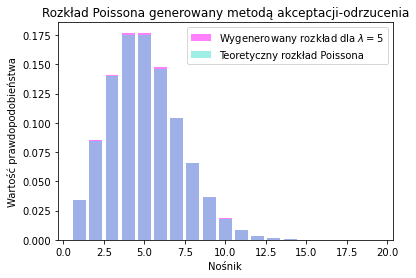

In [101]:
# parametry opisujące używane rozkłady
lmbd1 = 5
p1 = 0.1
n = 10**6

s = acceptance_rejection(1, lmbd1, p1)  # pierwsze wywołanie w celu kompilacji

t = perf_counter()
y = acceptance_rejection(n, lmbd1, p1)
t2 = perf_counter()
print(f"Czas: {t2-t}")
print(f"Skuteczność:{n/y[1] * 100} %")
counts, bins = np.histogram(y[0], bins=int(np.max(y[0])))
x = np.arange(1, len(counts)+1)
plt.bar(x, counts/n, label=f"Wygenerowany rozkład dla $\lambda = {lmbd1}$", alpha = 0.5, color = "Magenta")   # dzieląc przez n otrzymujemy gęstość
poisson = scipy.stats.poisson.pmf(x, lmbd1)
plt.bar(x, poisson, label="Teoretyczny rozkład Poissona", alpha = 0.5, color = "Turquoise")
plt.title("Rozkład Poissona generowany metodą akceptacji-odrzucenia")
plt.xlabel("Nośnik")
plt.ylabel("Wartość prawdopodobieństwa")
plt.legend()
plt.show()

#### Wywołanie metody dla $\lambda = 10$:

Czas: 0.63041770000018
Skuteczność:30.67184530102729 %


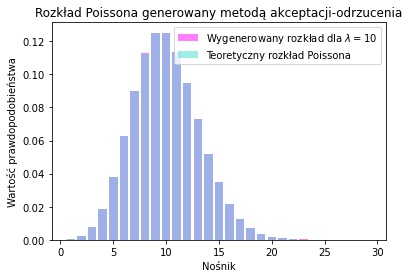

In [102]:
lmbd2 = 10

t = perf_counter()
y2 = acceptance_rejection(n, lmbd2, p1)
t2 = perf_counter()

print(f"Czas: {t2-t}")
print(f"Skuteczność:{n/y2[1]*100} %")

counts, bins = np.histogram(y2[0], bins=int(np.max(y2[0])))
x = np.arange(1, len(counts)+1)
plt.bar(x, counts/n, label=f"Wygenerowany rozkład dla $\lambda = {lmbd2}$", alpha = 0.5, color = "Magenta")   # dzieląc przez n otrzymujemy gęstość
poisson = scipy.stats.poisson.pmf(x, lmbd2)
plt.bar(x, poisson, label="Teoretyczny rozkład Poissona", alpha = 0.5, color = "Turquoise")
plt.title("Rozkład Poissona generowany metodą akceptacji-odrzucenia")
plt.xlabel("Nośnik")
plt.ylabel("Wartość prawdopodobieństwa")
plt.legend()
plt.show()

#### Wnioski:
* Jak możemy zauważyć, w obydwu przypadkach różnice w wygenerowanych oraz teoretycznych rozkładach są znikome. Na wykresie przeważa pokrycie się rozkładów, co reprezentowane jest zmieszaniem się kolorów poszczególnych figur. W niektórych miejscach dostrzegalne są cienkie paski w oryginalnych barwach. Ich mały rozmiar wskazuje na nieznaczne różnice pomiędzy rozkładami, a tym samym potwierdza poprawność symulacji.

## 3. Metoda zigguratu.

Poniżej zaimplementowana została przez nas metoda zigguratu generowania rozkładu normalnego poprzez rozkład wykładniczy. Skorzystaliśmy z kompilatora Numba w celu przyśpieszenia obliczeń. 

In [103]:
@njit
def zigguratu(samples, intervals, values):
    """Funkcja przyjmuje 3 argumenty:
    samples - liczba próbek rozkładu normalnego, którą chcemy wygenerować
    intervals - wartości, które otrzymaliśmy po podziale odcinka
    values - wartości funkcji gęstości rozkładu normalnego, które policzyliśmy w punktach 'intervals' 
    
    zwraca ona 3 elementy:
    outputs - wygenerowane próbki
    total_num - liczba wszystkich powtórzeń
    exp_count - liczba obliczeń funkcji wykładniczej
    
    Funkcja ta jest implementacją metody zigguratu generowania rozładu normalnego
    na podstawie rozkładu wykładniczego."""
    outputs = np.empty(samples, np.float_)
    index = 0
    total_num = 0
    exp_count = 0
    c = np.sqrt(np.e/(np.pi*2))  # stała c niezbędna do następnych obliczeń
    while index < samples:
        Y = -np.log(np.random.rand())   # rozkład wykładniczy z parametrem lambda=1 generowany metodą odwrotnej dystrybuanty
        U = np.random.rand()
        div_index = np.searchsorted(intervals, Y)   # funkcja zwracająca indeks, po którego wstawieniu danej wartości w tablicę nie zmieni się porządek
        if U * c * np.exp(-Y) < np.take(values, div_index):
            sign = np.random.rand()
            if sign > 0.5:   # dolosowywany znak próbki z jednakowym prawdopodobieństwem
                outputs[index] = Y
            else:
                outputs[index] = -Y
            index += 1
            total_num += 1
        elif U * c * np.exp(-Y) > np.take(values, div_index-1):
            total_num += 1
        else:
            exp_count += 1
            if U <= np.exp((Y**2)/-2 + Y)/(c*np.sqrt(2*np.pi)):
                sign = np.random.rand()
                if sign > 0.5:
                    outputs[index] = Y
                else:
                    outputs[index] = -Y
                index += 1
                total_num += 1
            else:
                total_num += 1
    return outputs, total_num, exp_count

#### Generowanie rozkładu normalnego $N(0,1)$ metodą zigguratu:

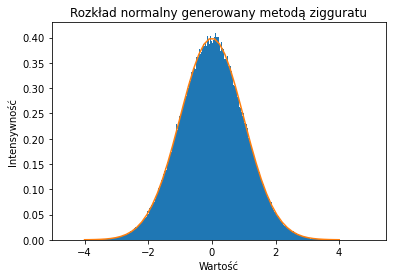

In [104]:
n = 10**6    # liczba próbek którą chcemy wygenerować
division1 = np.linspace(0, 25, 100)    # odcinek [0,25], równo podzielony na 100 elementów
values1 = scipy.stats.norm.pdf(division1)  # obliczone wartości rozkładu normalnego w punktach podziału

# Pierwsze wywołanie w celu kompilacji
y = zigguratu(1, division1, values1)

y = zigguratu(n, division1, values1)
x = np.linspace(-4, 4)
norm = scipy.stats.norm.pdf(x)
plt.hist(y[0], bins='sqrt', density=True, label = "wygenerowany rozkład")
plt.plot(x,norm, label = "gęstość teoretyczna")
plt.title("Rozkład normalny generowany metodą zigguratu")
plt.ylabel("Intensywność")
plt.xlabel("Wartość")
plt.show()

Możemy zauważyć, że histogram wygenerowanego rozkładu jest zgodny z gęstością rozkładu normalnego. Jest to zatem potwierdzenie skuteczności wykonanej symulacji.

Poniżej obliczymy procent obliczeń funkcji wykładniczej podczas generowania próbek, względem rozmiaru podziału odcinka na którym bazuje algorytm. Posłuży nam do tego prosta pętla w której zmieniane będą te wartości.

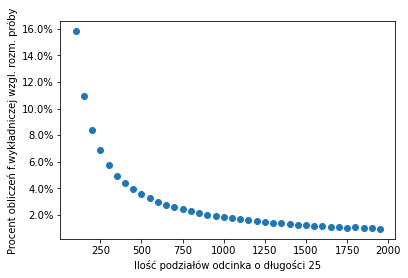

In [105]:
ranges = range(100, 2000, 50)
elems = len(ranges)
results = np.empty(elems)
percent_results = np.empty(elems)
index2 = 0
for i in ranges:
    division = np.linspace(0, 25, i)
    values2 = scipy.stats.norm.pdf(division)
    y = zigguratu(n, division, values2)
    results[index2] = y[2]
    percent_results[index2] = y[2]/len(y[0])*100
    index2 += 1

fig, ax = plt.subplots()
plt.scatter(ranges, percent_results)
plt.ylabel("Procent obliczeń f.wykładniczej wzgl. rozm. próby")
plt.xlabel("Ilość podziałów odcinka o długości 25")
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

Intrygującą własnością wygenerowanego powyżej wykresu jest fakt, że przyjmuje on kształt rozkładu wykładniczego. 

## 4. Generowanie rozkładu normalnego.


W tym zadaniu porównujemy efektywność generowania rozkładu normalnego za pomocą różnych metod. Są to:
* metoda wbudowana,
* metoda odwrotnej dystrybuanty,
* metoda akceptacji-odrzucenia,
* metoda zigguratu
* metoda Boxa-Mullera,
* metoda Marsaglii.

W każdym przypadku, za pomocą funkcji perf_counter(), oszacowaliśmy średni czas pojedynczego wywołania na podstawie k wywołań. Wykonaliśmy również testy statystyczne: Kołmogorowa-Smirnowa i Jarque-Bera. Ponownie skorzystaliśmy z kompilatora Numba w celu przyspieszenia obliczeń.

#### Parametry generowanego rozkładu:

In [106]:
mi = 0
sigma = 1
n = 10**5
k = 1000 # ilość wykonań danej metody
times = np.zeros(8) # tablica czasów wykonania dla analizowanych metod
jbtests_st, kstests_st, jbtests_pv, kstests_pv = np.zeros([4, 7])

### Metoda wbudowana:

In [107]:
t = perf_counter()
for i in range(k):
    r_normalny = np.random.normal(size = n, loc = mi, scale = sigma)
t2 = perf_counter()
times[0] = (t2-t)/k
print(f"Czas: {times[0]}")

Czas: 0.0025937838999998348


### Metoda odwrotnej dystrybuanty:

In [108]:
t = perf_counter()
for i in range(k):
    r_jednostajny = numpy.random.uniform(size=n)
    inv_norm = sigma*np.sqrt(2) * scipy.special.erfinv(2*r_jednostajny-1) + mi
t2 = perf_counter()
times[1] = (t2-t)/k
print(f"Czas: {times[1]}")

print("Testy statystyczne:")
test1 = scipy.stats.kstest(rvs=inv_norm, cdf=lambda xn: 1/2 * (1 + scipy.special.erf((xn-mi)/(sigma*np.sqrt(2)))))
print(test1)
test2 = scipy.stats.jarque_bera(inv_norm)
print(test2)

Czas: 0.003266851899999892
Testy statystyczne:
KstestResult(statistic=0.0023865568462198145, pvalue=0.6183831870564245)
Jarque_beraResult(statistic=2.180086406023139, pvalue=0.3362019684554355)


### Metoda akceptacji-odrzucenia:

In [109]:
@njit
def generator2(samples):
    """Funkcja przyjmuje jeden argument:
    samples - ilość próbek rozkładu normalnego, które chcemy wygenerować
    
    Zwraca ona natomiast dwa elementy:
    outputs - wygenerowane próbki
    total_num - liczbę wszystkich powtórzeń, służącą do liczenia skuteczności
    
    Funkcja ta jest implementacją metody akceptacji-odrzucenia generowania
    rozkładu normalnego na podstawie rozkładu wykładniczego"""    
    outputs = np.empty(samples)
    index = 0
    total_num = 0
    c = np.sqrt(2*np.e/np.pi)
    while index < samples:
        Y = -np.log(np.random.rand())
        U = np.random.rand()
        if U <= 2*np.exp((Y**2)/-2 + Y)/(c*np.sqrt(2*np.pi)):
            U2 = np.random.rand()
            if U2 > 0.5:
                outputs[index] = Y
            else:
                outputs[index] = -Y
            index += 1
            total_num += 1
        else:
            total_num += 1
    return outputs, total_num


c = np.sqrt(2*np.e/np.pi)
y = generator2(1) # pierwsze wywołanie w celu kompilacji

t = perf_counter()
for i in range(k):
    akc_odr = generator2(n)
t2 = perf_counter()
times[2] = (t2-t)/k
print(f"Czas: {times[2]}")

print("Testy statystyczne:")
test1 = scipy.stats.kstest(rvs=akc_odr[0], cdf=lambda xn: 1/2 * (1 + scipy.special.erf((xn-mi)/(sigma*np.sqrt(2)))))
print(test1)
test2 = scipy.stats.jarque_bera(akc_odr[0])
print(test2)

Czas: 0.005299512499999764
Testy statystyczne:
KstestResult(statistic=0.002111048562738582, pvalue=0.7634709018057707)
Jarque_beraResult(statistic=2.5628997028277265, pvalue=0.27763447976566025)


### Metoda zigguratu:

Metoda została zaimplementowana analogicznie jak w przypadku zadania 3.

In [110]:
@njit
def zigguratu(samples, intervals, values):
    """Funkcja przyjmuje 3 argumenty:
    samples - liczba próbek rozkładu normalnego, którą chcemy wygenerować
    intervals - wartości, które otrzymaliśmy po podziale odcinka
    values - wartości funkcji gęstości rozkładu normalnego, które policzyliśmy w punktach 'intervals' 
    
    zwraca ona 3 elementy:
    outputs - wygenerowane próbki
    total_num - liczba wszystkich powtórzeń
    exp_count - liczba obliczeń funkcji wykładniczej
    
    Funkcja ta jest implementacją metody zigguratu generowania rozładu normalnego
    na podstawie rozkładu wykładniczego."""
    outputs = np.empty(samples, np.float_)
    index = 0
    total_num = 0
    exp_count = 0
    c = np.sqrt(np.e/(np.pi*2))  # stała c niezbędna do następnych obliczeń
    while index < samples:
        Y = -np.log(np.random.rand())   # rozkład wykładniczy z parametrem lambda=1 generowany metodą odwrotnej dystrybuanty
        U = np.random.rand()
        div_index = np.searchsorted(intervals, Y)   # funkcja zwracająca indeks, po którego wstawieniu danej wartości w tablicę nie zmieni się porządek
        if U * c * np.exp(-Y) < np.take(values, div_index):
            sign = np.random.rand()
            if sign > 0.5:   # dolosowywany znak próbki z jednakowym prawdopodobieństwem
                outputs[index] = Y
            else:
                outputs[index] = -Y
            index += 1
            total_num += 1
        elif U * c * np.exp(-Y) > np.take(values, div_index-1):
            total_num += 1
        else:
            exp_count += 1
            if U <= np.exp((Y**2)/-2 + Y)/(c*np.sqrt(2*np.pi)):
                sign = np.random.rand()
                if sign > 0.5:
                    outputs[index] = Y
                else:
                    outputs[index] = -Y
                index += 1
                total_num += 1
            else:
                total_num += 1
    return outputs, total_num, exp_count


division1 = np.linspace(0, 25, 100)
values1 = scipy.stats.norm.pdf(division1)
# lmbd = 1
tmp = zigguratu(1, division1, values1)

t = perf_counter()
for i in range(k):
    z = zigguratu(n, division1, values1)
t2 = perf_counter()
times[3] = (t2-t)/k
print(f"Czas: Metoda Zigguratu {times[3]}")

test1 = scipy.stats.kstest(rvs=z[0], cdf=lambda xn: 1/2 * (1 + scipy.special.erf((xn-mi)/(sigma*np.sqrt(2)))))
print(test1)
test2 = scipy.stats.jarque_bera(z[0])
print(test2)

Czas: Metoda Zigguratu 0.009090159100000165
KstestResult(statistic=0.0014027904017689385, pvalue=0.9891540341454511)
Jarque_beraResult(statistic=1.3285582412049044, pvalue=0.514644390555093)


### Metoda Boxa-Mullera:

W swoim założeniu algorytm Boxa-Mullera jest metodą generowania dwóch niezależnych zmiennych losowych z rozkładu normalnego. Bazuje ona na wygenerowaniu dwóch zmiennych losowych z rozkładu jednostajnego $U(0,1)$ i przekształceniu ich zgodnie z poniższymi wzorami:
* $X = \sqrt{-2 \log{U_1}}\cos{(2 \pi U_2)}$,
* $Y = \sqrt{-2 \log{U_1}}\sin{(2 \pi U_2)}$.

Na potrzeby zadania stworzyliśmy dwie odrębne funkcje służące do generacji $\underline{jednej}$ zmiennej losowej z rozkładu $N(\mu,\sigma)$:
* funkcja boxMullerC bazuje na wzorze z cosinusem,
* funkcja boxMullerS bauzje na wzorze z sinusem.

In [111]:
@njit
def boxMullerC(n):
    X = np.zeros(n)
    for i in range(n):
        U1 = np.random.rand()
        U2 = np.random.rand()
        x = np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)
        X[i] = sigma * x + mi

    return X

z = boxMullerC(1)

t = perf_counter()
for i in range(k):
    bmC = boxMullerC(n)
t2 = perf_counter()
times[4] = (t2-t)/k
print(f"Czas: Metoda Boxa-Mullera z cosinusem {times[4]}")

print("Testy statystyczne:")
test1 = scipy.stats.kstest(rvs=bmC, cdf=lambda xn: 1/2 * (1 + scipy.special.erf((xn-mi)/(sigma*np.sqrt(2)))))
print(test1)
test2 = scipy.stats.jarque_bera(bmC)
print(test2)

@njit
def boxMullerS(n):
    Y = np.zeros(n)
    for i in range(n):
        U1 = np.random.rand()
        U2 = np.random.rand()
        y = np.sqrt(-2 * np.log(U1)) * np.sin(2 * np.pi * U2)
        Y[i] = sigma * y + mi

    return Y

z = boxMullerS(1)

t = perf_counter()
for i in range (k):
    bmS = boxMullerS(n)
t2 = perf_counter()
times[5] = (t2-t)/k
print(f"Czas: Metoda Boxa-Mullera z sinusem {times[5]}") 

print("Testy statystyczne:")
test1 = scipy.stats.kstest(rvs=bmS, cdf=lambda xn: 1/2 * (1 + scipy.special.erf((xn-mi)/(sigma*np.sqrt(2)))))
print(test1)
test2 = scipy.stats.jarque_bera(bmS)
print(test2)

Czas: Metoda Boxa-Mullera z cosinusem 0.0033959052999998677
Testy statystyczne:
KstestResult(statistic=0.0021319083690487517, pvalue=0.7528419824294929)
Jarque_beraResult(statistic=0.3632307944219924, pvalue=0.8339220074769468)
Czas: Metoda Boxa-Mullera z sinusem 0.0032927254000005633
Testy statystyczne:
KstestResult(statistic=0.0020935842259016124, pvalue=0.7722829844024693)
Jarque_beraResult(statistic=2.407266448451653, pvalue=0.30010189132918763)


### Metoda Marsaglii:

Analogicznie jak w poprzednim przypadku, metoda Marsaglii służy do generowania dwóch niezależnych zmiennych losowych z norkładu normlanego. Jest ona pewnym przekształceniem metody Boxa-Mullera. Z tego powodu również tu zaimplementowaliśmy dwie odrębne funkcje bazujące na metodzie Marsaglii.

In [112]:
@njit
def marsaglii1(n):
    X = np.zeros(n)
    count = 0
    while (count<n):
        V1 = np.random.uniform(-1, 1) # ewentualnie to zmienić ze względu na numbę
        V2 = np.random.uniform(-1, 1)
        R2 = V1 ** 2 + V2 ** 2
        if (R2 <= 1):
            x = np.sqrt(-2 * np.log(R2)/R2) * V1
            X[count] = sigma * x + mi
            count += 1
    return X

z = marsaglii1(1) # pierwsze wywołanie w celu kompilacji

t = perf_counter()
for i in range (k):
    m1 = marsaglii1(n)
t2 = perf_counter()
times[6] = (t2-t)/k
print(f"Czas: Metoda Marsaglii wariant 1 {times[6]}") 

print("Testy statystyczne:")
test1 = scipy.stats.kstest(rvs=m1, cdf=lambda xn: 1/2 * (1 + scipy.special.erf((xn-mi)/(sigma*np.sqrt(2)))))
print(test1)
test2 = scipy.stats.jarque_bera(m1)
print(test2)

@njit
def marsaglii2(n):
    Y = np.zeros(n)
    count = 0
    while (count<n):
        V1 = np.random.uniform(-1, 1)
        V2 = np.random.uniform(-1, 1)
        R2 = V1 ** 2 + V2 ** 2
        if (R2 <= 1):
            y = np.sqrt(-2 * np.log(R2)/R2) * V2
            Y[count] = sigma * y + mi
            count += 1
    return Y

z = marsaglii2(1) # pierwsze wywołanie w celu kompilacji

t = perf_counter()
for i in range (k):
    m2 = marsaglii2(n)
t2 = perf_counter()
times[7] = (t2-t)/k
print(f"Czas: Metoda Marsaglii wariant 2 {times[7]}") 

print("Testy statystyczne:")
test1 = scipy.stats.kstest(rvs=m2, cdf=lambda xn: 1/2 * (1 + scipy.special.erf((xn-mi)/(sigma*np.sqrt(2)))))
print(test1)
test2 = scipy.stats.jarque_bera(m2)
print(test2)

Czas: Metoda Marsaglii wariant 1 0.003890795600000274
Testy statystyczne:
KstestResult(statistic=0.001510344434559302, pvalue=0.9762360172807838)
Jarque_beraResult(statistic=1.4056371767847353, pvalue=0.4951876049125685)
Czas: Metoda Marsaglii wariant 2 0.0036233368000011977
Testy statystyczne:
KstestResult(statistic=0.0027520444420920387, pvalue=0.4342839037888315)
Jarque_beraResult(statistic=0.2862359436096577, pvalue=0.8666518223848599)


#### Podsumowanie:

In [113]:
print("Metoda wbudowana - czas:                 ", times[0])
print("Metoda odwrotnej dystrybuanty - czas:    ", times[1])
print("Metoda akceptacji-odrzucenia - czas:     ", times[2])
print("Metoda zigguratu - czas:                 ", times[3])
print("Metoda Boxa-Mullera z cosinusem - czas:  ", times[4])
print("Metoda Boxa-Mullera z sinusem - czas:    ", times[5])
print("Metoda Marsaglii wariant 1 - czas:       ", times[6])
print("Metoda Marsaglii wariant 2 - czas:       ", times[7])

Metoda wbudowana - czas:                  0.0025937838999998348
Metoda odwrotnej dystrybuanty - czas:     0.003266851899999892
Metoda akceptacji-odrzucenia - czas:      0.005299512499999764
Metoda zigguratu - czas:                  0.009090159100000165
Metoda Boxa-Mullera z cosinusem - czas:   0.0033959052999998677
Metoda Boxa-Mullera z sinusem - czas:     0.0032927254000005633
Metoda Marsaglii wariant 1 - czas:        0.003890795600000274
Metoda Marsaglii wariant 2 - czas:        0.0036233368000011977


#### Wnioski:
* pomimo zastosowania kompilatora Numba, wciąż najszybsza pozostaje wbudowana metoda generowania rozkładu normalnego,
* metoda odwrotnej dystrybuanty jest jedną z najszybszych, wynika to z jej prostoty,
* atrakcyjne wydają się być metoda Boxa-Mullera w obu wariantach oraz metoda Marsaglii również w obu wariantach,
* metoda akceptacji-odrzucenia jest około dwa razy wolniejsza od dwóch poprzednich, nie jest zatem tak atrakcyjna,
* zdecydowanie najdłuższy czas generacji przejawia metoda zigguratu, jej wydajność zapewnie wzrosłaby względem pozostałych w momencie generowania rozkładu o bardziej kosztownej w wyliczaniu numerycznie funkcji gęstości,
* przy każdym wywołaniu wartości testów statystycznych zmieniają się, ale pozostają w akceptowalnych granicach.


## 5. Zależność zmiennych losowych

W tym zadaniu analizujemy wpływ stopnia zależności dwóch zmiennych losowych $X$ i $Y$ na następujące rozkłady:
* $X + Y$,
* $X - Y$,
* $X^2 + Y^2$. 

#### Parametry dla zmiennych losowych $X$ i $Y$:

In [114]:
mi1 = 0
sigma1 = 1
mi2 = 0
sigma2 = 2
n = 10**5

#### Histogramy:
W pierwszym kroku za pomocą histogramów przedstawimy wyżej wspomniane rozkłady. <br> W celu uzyskania przejrzystości na wykresie, rozważyliśmy pięć wartości współczynnika korelacji: $-1$, $-0.5$, $0$ (zmienne niezależne), $0.5$ oraz $1$.

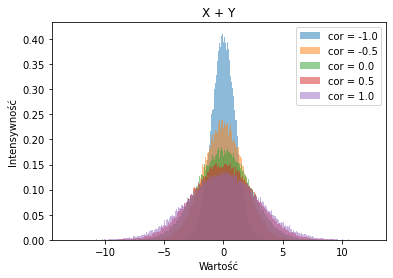

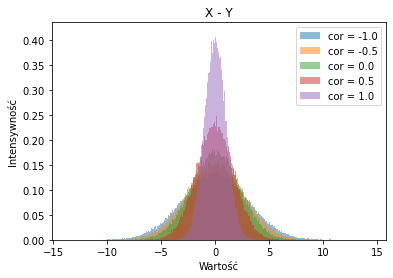

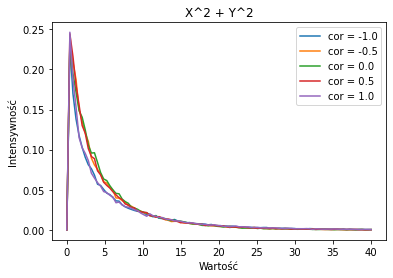

In [115]:
k = 5 
Cor = np.array(np.linspace(-1, 1, k))

for i, cor in enumerate(Cor):
    cov_matrix = np.array([[sigma1 ** 2, cor * sigma1 * sigma2], [cor * sigma1 * sigma2, sigma2 ** 2]])
    x, y = np.random.multivariate_normal([mi1, mi2], cov_matrix, size = n).T
    z = x + y
    plt.hist(z, alpha = 0.5, bins = "sqrt", density = True, label = "cor = {}".format(cor))  # this is new, labelsy do dopasowania
plt.ylabel("Intensywność")
plt.xlabel("Wartość")
plt.legend()
plt.title("X + Y")
plt.show()


for i, cor in enumerate(Cor):
    cov_matrix = np.array([[sigma1 ** 2, cor * sigma1 * sigma2], [cor * sigma1 * sigma2, sigma2 ** 2]])
    x, y = np.random.multivariate_normal([mi1, mi2], cov_matrix, size = n).T
    w = x - y
    plt.hist(w, alpha = 0.5, bins="sqrt", density = True, label = "cor = {}".format(cor))
plt.ylabel("Intensywność")
plt.xlabel("Wartość")
plt.legend()
plt.title("X - Y")
plt.show()

   
for i, cor in enumerate(Cor):
    cov_matrix = np.array([[sigma1 ** 2, cor * sigma1 * sigma2], [cor * sigma1 * sigma2, sigma2 ** 2]])
    x, y = np.random.multivariate_normal([mi1, mi2], cov_matrix, size = n).T
    t = x **2 + y **2
    hist = np.histogram(t, bins = "sqrt", density= True)
    hist_dist = scipy.stats.rv_histogram(hist)
    X = np.linspace(0, 40.0, 100)
    plt.plot(X, hist_dist.pdf(X), label = "cor = {}".format(cor))
plt.ylabel("Intensywność")
plt.xlabel("Wartość")
plt.legend()
plt.title("X^2 + Y^2")
plt.show()

#### Wartość oczekiwana i wariancja:
Następnie przeprowadzimy analizę dla wartości oczekiwanej i wariancji w zależności od skorelowania zmiennych $X$ i $Y$. Tym razem mogliśmy pozwolić sobie na rozważenie większej ilości współczynników korelacji.

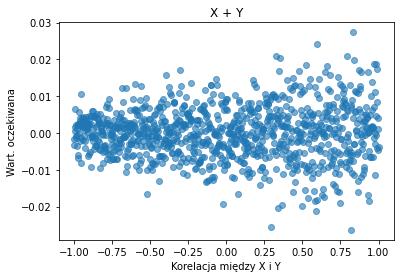

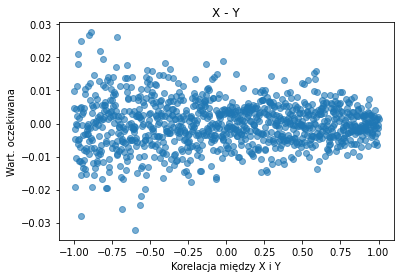

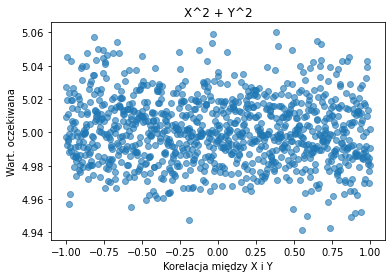

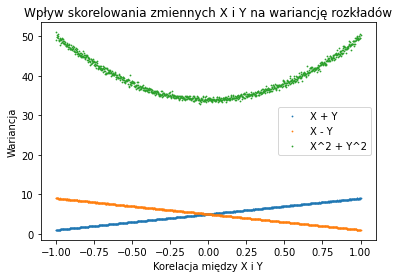

In [116]:
k = 1000
correlations = np.linspace(-1, 1, k)
variance = np.zeros((len(correlations), 3))
mean = np.zeros((len(correlations), 3))

for i, corr in enumerate(correlations):
    cov_matrix = np.array([[sigma1 ** 2, corr * sigma1 * sigma2], [corr * sigma1 * sigma2, sigma2 ** 2]])
    x, y = np.random.multivariate_normal([mi1, mi2], cov_matrix, size=n).T
    variance[i, 0] = np.var(x + y)
    variance[i, 1] = np.var(x - y)
    variance[i, 2] = np.var(x**2 + y**2)
    mean[i, 0] = np.mean(x + y)
    mean[i, 1] = np.mean(x - y)
    mean[i, 2] = np.mean(x**2 + y**2)

plt.scatter(correlations, mean[:, 0], alpha = 0.6)
plt.ylabel("Wart. oczekiwana")
plt.xlabel("Korelacja między X i Y")
plt.title("X + Y")
plt.show()
plt.scatter(correlations, mean[:, 1], alpha = 0.6)
plt.ylabel("Wart. oczekiwana")
plt.xlabel("Korelacja między X i Y")
plt.title("X - Y")
plt.show()
plt.scatter(correlations, mean[:, 2], alpha = 0.6)
plt.ylabel("Wart. oczekiwana")
plt.xlabel("Korelacja między X i Y")
plt.title("X^2 + Y^2")
plt.show()

plt.scatter(correlations, variance[:, 0], label='X + Y', s = 0.6)
plt.scatter(correlations, variance[:, 1], label='X - Y', s = 0.6)
plt.scatter(correlations, variance[:, 2], label='X^2 + Y^2', s = 0.6)
plt.xlabel("Korelacja między X i Y")
plt.ylabel("Wariancja")
plt.title("Wpływ skorelowania zmiennych X i Y na wariancję rozkładów")
plt.legend()
plt.show()

#### Wnioski:

Wraz ze wzrostem stopnia zeleżności między $X$ i $Y$:
* dla rozkładu $X+Y$:
    * wartości oczekiwane stają się coraz bardziej rozproszone,
    * wariancje ich sumy rosną w sposób liniowy,
    
    
* dla rozkładu $X-Y$:
    * wartości oczekiwane stają się coraz mniej rozproszone,
    * wariancje ich różnicy maleją liniowo,
    
    
* dla rozkładu $X^2+Y^2$:
    * wartości oczekiwane są względnie równomiernie rozmieszczone,
    * wariancja 
    
    
Histogramy wygenerowane w pierwszym etapie naszego rozwiązania potwierdzają powyższe obserwacje.